<a href="https://colab.research.google.com/github/Reedr1208/Audio_Effect_Detection/blob/main/Audio_Effect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Effects Parameter Estimation Using Deep Learning

### Overview

As a musician, I often want to recreate guitar effects that I hear on recordings from my favorite bands. However, finding the right effects and parameters to use is not always easy. I would love to have a tool which can take an audio input and tell me which effects I need to use and how I should set their various parameters. This project is an attempt to use deep learning to achieve a simplified version of this tool. 

### Goal

I will be attempting to estimate 2 different parameters simultaneously:
- "Reverberance" parameter of a reverb effect (0.0-1.0)
- "Decay" parameter of an echo effect (0.0-1.0)

The reverberance can be though of as the length of the reverb. The decay parameter is the amplitude percentage of the original sound which the first echo will have (higher number is a louder echo). For this project, other parameters will be held constant. 

If this project achieves its goal, that will open the door for expanding the project to handle a wider variety of effects and types of audio data.

### The Data

I have recorded 40 minutes of clean electric guitar to be used as my dataset. This recording includes a variety of playing styles (strumming, fast picking, harmonics, finger picking, etc.). Much of it is structureless, dissonant and quite frankly, ugly, in order to provide the greatest variety of information and avoid the repetition that comes with playing actual songs.  

For training my model, I will fetch random 3 second clips and apply a random amount of reverberance (reverb) and decay (echo) to each clip. These randomly generated parameter settings will be treated as my training labels. 

70% of the data will be used for training and 15% for validation and testing.

### Methods

When applying deep learning to audio, Spectrograms are commonly used. A spectrogram is a visual representation of an audio clip with time on the horizontal axis, frequency on the vertical axis, with amplitude represented by pixel intensity. I will be using two different convolutional neural network architectures in an attempt to infer the echo and reverb settings using the spectrogram images. 

The first model architecture will have a single branch with two different linear outputs to estimate each parameter value. The second model architecture will have two independent branches which are decidated to reverb and echo respectively. 

### Evaluation

I will be evaluating models using mean squared error and will be comparing my models performance with a benchmark performance. This benchmark performance will be the performance of a model which always predicts the expectation value for each parameter (0.5). The full model's loss will simply be the sum of the MSE for reverb and echo outputs. 

__________________________________________________________________
<br><br>



Install the pysndfx library and install sox (Sound eXchange)

The pysndfx library is a python wrapper for sox which will be used to programatically apply effects with the desired parameters. See documentation for each below.

sox: http://sox.sourceforge.net/sox.html

pysndfx: https://github.com/carlthome/python-audio-effects



In [1]:
!pip install pysndfx
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null

  Created wheel for pysndfx: filename=pysndfx-0.3.6-py3-none-any.whl size=6555 sha256=026fb263883c82b7efdc054cfa7ef017312ad96b14eb3302fb40290ce9f0bac3
  Stored in directory: /root/.cache/pip/wheels/2d/23/4c/8595647068440dec987dc615c4f5a7c64ba0e11364195cd568
Successfully built pysndfx


Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import librosa
from pysndfx import AudioEffectsChain
import random
import matplotlib.pyplot as plt
import librosa.display
import warnings
import cv2
from tensorflow.keras import Model, models, layers, callbacks
warnings.filterwarnings('ignore')
import IPython.display as ipd
import math
import soundfile as sf
import datetime
import pickle
import os
import pandas as pd
import seaborn as sns

# Define Utility Functions

Define utility functions for applying effects, generating spectrograms, and displaying spectrograms

In [2]:
def generate_fx_clip(path=None, 
                  sample_audio=None, 
                  sample_sr=None, 
                  reverb=0.0,
                  echo=0.0):
  """
  accepts a clean sound clip as input and returns a sound clip with desired effects
  returned value in a numpy ndarray

  Input options:
    1. Provide "path" and omit "sample_audo" and "sample_sr"
    2. Omit "path" and provide "sample_audo" and "sample_sr"'''
  """

  #validity checks for input
  #echo and reverb between 0 and 1
  assert all([0<=i<=1 for i in [reverb, echo]]), 'Reverb and Echo must be in range [0.0,1.0]'
      
  echo= round(echo, 2)
  reverb= round(reverb, 2)

  #convert from float in [0,1] to native integer input
  reverb= int(100*reverb)
  if path!=None:
    sample_audio, sample_sr = librosa.load(path=path, sr=None)
  fx = (
        AudioEffectsChain()
        .delay(delays = [100, 200], decays=[echo, echo*0.2])
        .reverb(reverberance=reverb)
          )
  sample_audio= fx(sample_audio)
  return sample_audio, sample_sr

def build_spectrogram(sample_audio, 
                      sample_sr,
                      convert_to_db=False,
                      target_size=None): #target_size like (height, width)
  """
  Takes an audio clip as input and returns the spectrogram in ndarray form
  Can optionally adjust to decibels for better human viewing
  Can optionally resize the spectrogram image
  """
  sgram = librosa.stft(sample_audio, n_fft=512)
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_sr)
  
  if convert_to_db:
    mel_scale_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
  if target_size!=None:
    mel_scale_sgram = cv2.resize(mel_scale_sgram, dsize=target_size, interpolation=cv2.INTER_CUBIC)
  
  return mel_scale_sgram

def draw_spectrogram(title, 
                     path, 
                     reverb, 
                     echo, 
                     convert_to_db=True, 
                     target_size=None, 
                     font_size=16):
  """
  Display a spectrogram according to input
  """
  sample_audio, sample_sr = generate_fx_clip(path, echo=echo, reverb=reverb)
  mel_scale_sgram = build_spectrogram(sample_audio, 
                        sample_sr,
                        convert_to_db=convert_to_db,
                        target_size=target_size)

  #plt.figure(figsize=(10, 6))
  plt.title(title, size=font_size)
  #scales will lose meaning if not converted to db or if the image size is altered
  if not convert_to_db or target_size:
    plt.imshow(mel_scale_sgram)
    return
  librosa.display.specshow(mel_scale_sgram, sr=sample_sr, hop_length=128, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')


# Define Custom Data Generator

A custom generator will be built for preparing the training, validation, and testing data. A batch of sound clips will be grabbed from the data set. By default, the batch size is 20 and the length of these clips is 3 seconds. These sound clips will be chosen from random start times and the effect parameters chosen for each clip will be random. This ensures that data is not repeated. 

The \_\_get_item\_\_  method also returns the chosen effects parameters which are treated as the labels during training and evaluation. 

In [3]:
class AudioDataGen(tf.keras.utils.Sequence):

    #will take the path to sound file as arg
    #will load in full sound file
    def __init__(self, audio_path,
                 batch_size = 20,
                 generator_type='training', #training, validation, testing
                 sample_length = 3, # in seconds
                 target_size=None):
        self.generator_type= generator_type
        self.audio_path = audio_path
        self.batch_size = batch_size
        self.target_size= target_size
        self.full_audio, self.sr = librosa.load(path=audio_path, sr=None)
        self.max_start = self.full_audio.shape[0] - sample_length*self.sr
        self.sample_length= sample_length


    #will take a list of random starting times equal to batch size
    def prep_input(self, start_time=0, reverb=0, echo=0, sample_length=None, save_samples=False, return_audio=False):
        if sample_length==None:
            sample_length= self.sample_length
        
        audio_slice= self.full_audio[start_time:start_time+(self.sr*sample_length)]
        
        #apply effects
        audio_slice, _ = generate_fx_clip(sample_audio= audio_slice, 
                                          sample_sr=self.sr,
                                          reverb=reverb,
                                          echo=echo)
        #trim off any growth from effects
        audio_slice= audio_slice[0:self.sr*sample_length]
        
        #return sound clip with effects instead of spectrogram
        if return_audio:
          return audio_slice

        if save_samples==True:
          outfile= '/Users/raymondreed/Downloads/out_{}_{}_{}.wav'.format(round(start_time/self.sr), int(100*reverb), int(100*echo))
          fx(audio_slice, outfile)

        #build spectrogram from audio with fx
        audio_slice= build_spectrogram(audio_slice, 
                              self.sr,
                              target_size=self.target_size)
        audio_slice/=audio_slice.max()
        #for compatibility with tensorflow
        audio_slice= np.expand_dims(audio_slice, 2)
        #mel_scale_sgram= np.repeat(mel_scale_sgram, 3, 2)
        #print(mel_scale_sgram.shape)
        
        return audio_slice
        
        # Generates data containing batch_size samples
        
        

    #main fuction. batches will be a list of random starting times for 4 second chunks
    #will also include randomly selected delay and reverb params
    #the label will be divided by 100 for reverb so that outputs are on same scale
    #batch spectograms will be fetched from __get_data function
    #index comes from the fit function. One option is to split original file and use index to choose with chunk to choose from
    def generate_fx_params(self):
        start_times = random.sample(range(0, self.max_start+1), self.batch_size)
        reverbs = np.random.uniform(size=self.batch_size).round(2)
        echoes= np.random.uniform(size=self.batch_size).round(2)
        return list(zip(start_times, reverbs, echoes))
    
    def __getitem__(self, index):
        #start time is the sample index, not seconds
        
        fx_params= self.generate_fx_params()
        reverbs= np.array([j for i, j, k in fx_params])
        echoes= np.array([k for i, j, k in fx_params])
        
        X = np.asarray([self.prep_input(i, j, k) for i, j, k  in fx_params])
        y= {'reverb_output': reverbs, 'echo_output': echoes}
        return X, y
        

    def __len__(self):
      if self.generator_type=='training':
        return 100*self.full_audio.shape[0] // (self.sr*self.sample_length)
      else:
        #arbitrarily high number to avoid tensorflow error claiming dataset isn't large enough for evaluation
        return 10**9
        
    

# Data Visualization

### Run the following to apply various echo & revert to sample clip

Choose echo value between 0.0 and 1.0: 0.6
Choose reverb value between 0.0 and 1.0: 0.7

 Echo: 0.6, Reverb: 0.7


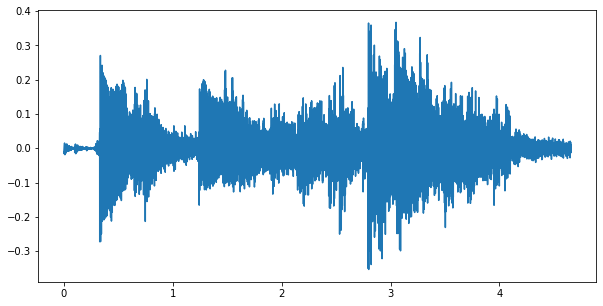

In [84]:

echo= float(input('Choose echo value between 0.0 and 1.0: '))
reverb= float(input('Choose reverb value between 0.0 and 1.0: '))
print('\n Echo: {}, Reverb: {}'.format(echo, reverb))

sample_audio, sample_sr = generate_fx_clip(path='clip.wav', echo=echo, reverb=reverb)
seconds= np.array(range(len(sample_audio)))/sample_sr
plt.figure(figsize=(10,5))
plt.plot(seconds, sample_audio)
ipd.Audio(sample_audio, rate=sample_sr) # load a local WAV file


Display spectrogram of the sound clip above (original and with sound effects)

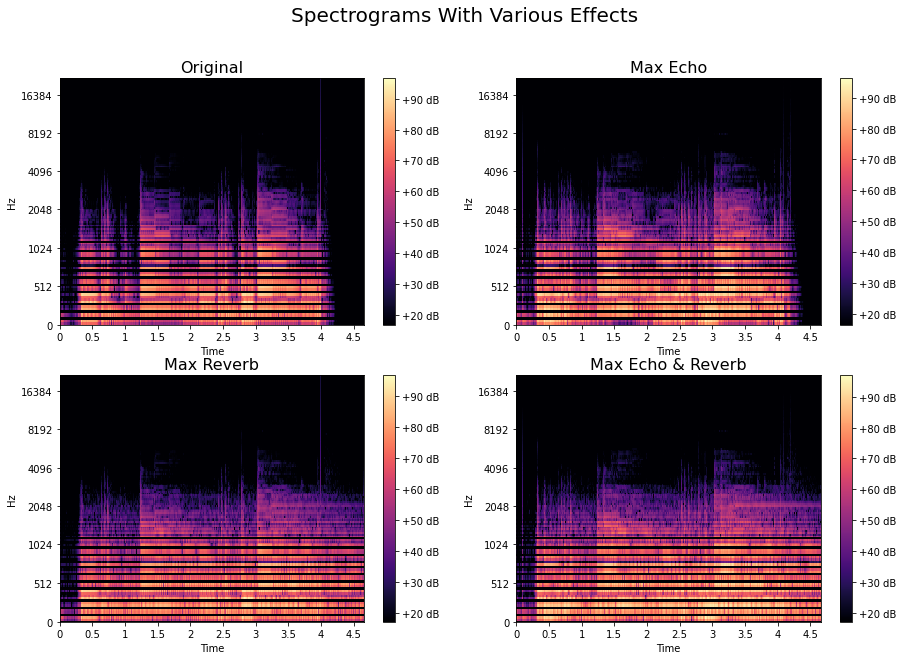

In [ ]:
fig = plt.figure(figsize= (15, 10))
fig.suptitle('Spectrograms With Various Effects', fontsize=20)
ax=fig.add_subplot(221)
draw_spectrogram('Original', 'clip.wav', reverb=0.0, echo=0.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(222)
draw_spectrogram('Max Echo', 'clip.wav', reverb=0.0, echo=1.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(223)
draw_spectrogram('Max Reverb', 'clip.wav', reverb=1.0, echo=0.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(224)
draw_spectrogram('Max Echo & Reverb', 'clip.wav', reverb=1.0, echo=1.0, convert_to_db=True, target_size=None)

When comparing the original to the "max echo" spectrogram, we can see a doubling of the shapes in "max echo" visual. In the "max reverb" visual, we can see that the visual is more "smeared out". We see a combination of these effects in the "max echo & reverb" visual. 

Our model will rely on these spectrograms to estimate the parameter settings. The fact that we can see the visual manifestation of these effects is promising. 

I will now display 4 spectrograms with varying levels of echo and no reverb.

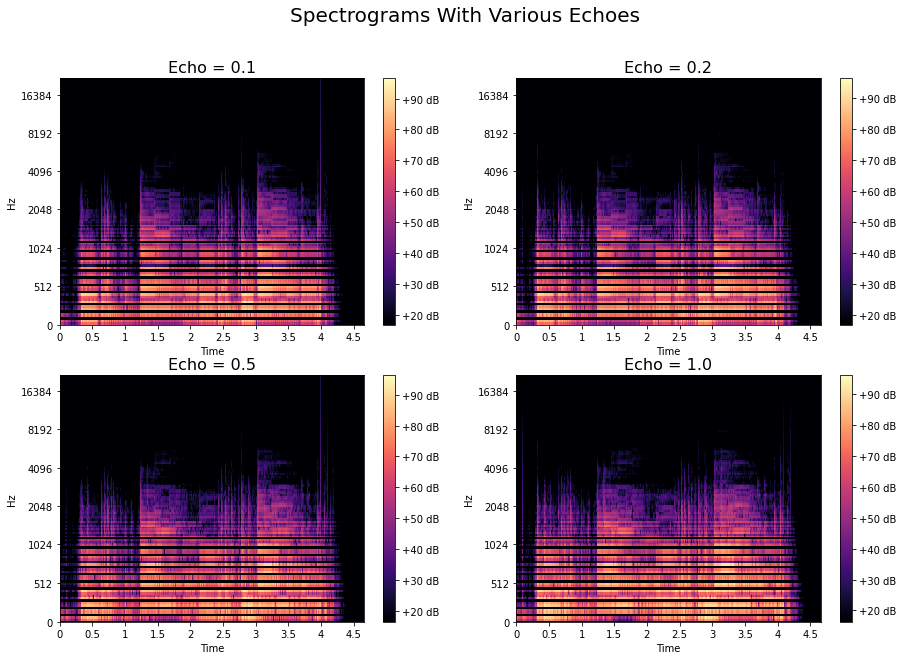

In [ ]:
fig = plt.figure(figsize= (15, 10))
fig.suptitle('Spectrograms With Various Echoes', fontsize=20)
ax=fig.add_subplot(221)
draw_spectrogram('Echo = 0.1', 'clip.wav', reverb=0.0, echo=0.1, convert_to_db=True, target_size=None)
ax=fig.add_subplot(222)
draw_spectrogram('Echo = 0.2', 'clip.wav', reverb=0.0, echo=0.2, convert_to_db=True, target_size=None)
ax=fig.add_subplot(223)
draw_spectrogram('Echo = 0.5', 'clip.wav', reverb=0.0, echo=0.5, convert_to_db=True, target_size=None)
ax=fig.add_subplot(224)
draw_spectrogram('Echo = 1.0', 'clip.wav', reverb=0.0, echo=1.0, convert_to_db=True, target_size=None)

Above, we can see that the doubling of the spectrogram shapes becomes more prominent as we increase the echo. Again, this looks promising as we have evidence that the level of echo can be inferred from the spectrogram. 

I will now display 4 spectrograms with varying levels of reverb.

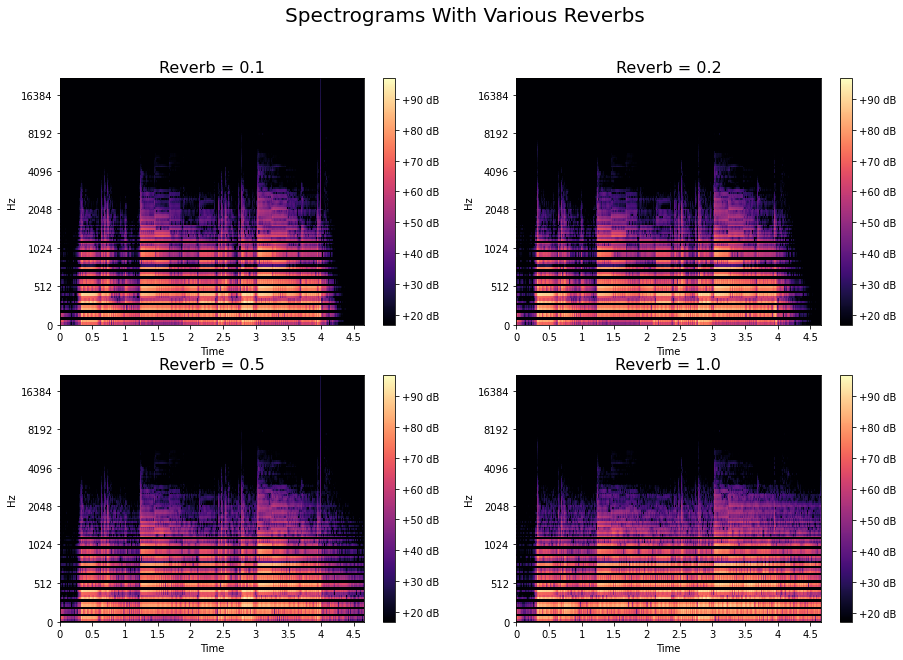

In [ ]:
fig = plt.figure(figsize= (15, 10))
fig.suptitle('Spectrograms With Various Reverbs', fontsize=20)
ax=fig.add_subplot(221)
draw_spectrogram('Reverb = 0.1', 'clip.wav', reverb=0.1, echo=0.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(222)
draw_spectrogram('Reverb = 0.2', 'clip.wav', reverb=0.2, echo=0.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(223)
draw_spectrogram('Reverb = 0.5', 'clip.wav', reverb=0.5, echo=0.0, convert_to_db=True, target_size=None)
ax=fig.add_subplot(224)
draw_spectrogram('Reverb = 1.0', 'clip.wav', reverb=1.0, echo=0.0, convert_to_db=True, target_size=None)

Similarly, we can see that the degree of "smearing" increases as we turn up the reverb. This is again promising, but these images aren't exactly what our model will be seeing.

I will now display 3 different versions of a spectrogram with max echo:

1) A spectrogram that has been converted to decibels and reshaped

2) The raw spectrogram with no reshaping or conversion to decibels

3) A spectrogram with has been reshaped to (256,256) but not converted to decibels

Our models will be fed version 3. Although the first image is most visually digestible for humans, machine learning models typically work better with spectrograms which have not been converted to decibels. 

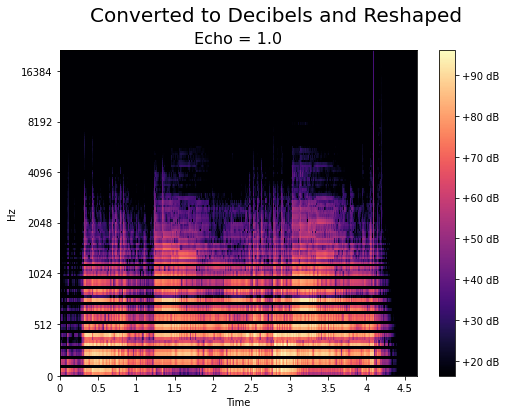

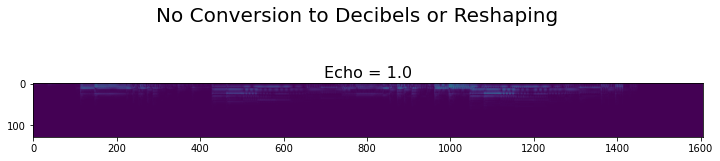

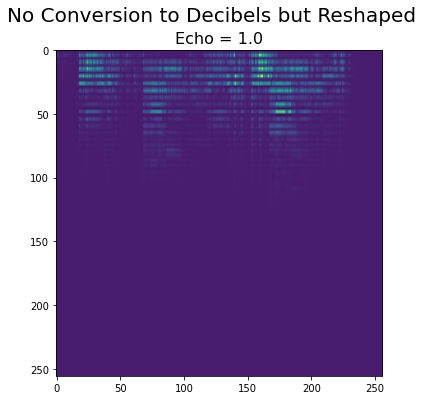

In [ ]:
fig = plt.figure(figsize= (8, 6))
fig.suptitle('Converted to Decibels and Reshaped', fontsize=20)
draw_spectrogram('Echo = 1.0', 'clip.wav', reverb=0.0, echo=1.0, convert_to_db=True, target_size=None)
fig = plt.figure(figsize= (12, 3))
fig.suptitle('No Conversion to Decibels or Reshaping', fontsize=20)
draw_spectrogram('Echo = 1.0', 'clip.wav', reverb=0.0, echo=1.0, convert_to_db=False, target_size=None)
fig = plt.figure(figsize= (8, 6))
fig.suptitle('No Conversion to Decibels but Reshaped', fontsize=20)
draw_spectrogram('Echo = 1.0', 'clip.wav', reverb=0.0, echo=1.0, convert_to_db=False, target_size=(256,256))

We can still see the doubling of shapes in the 3rd image which suggests that the information we are interested in is still identifiable. We are now ready to begin building our models. 

# Model Building

### Splitting out Validation and Testing Sets

The training, validation, and testing data will be split out from the full sound clip as shown in the following image.

When recording the full sound clip, I was sure to frequently change the playing style, so all three sets shound be representative of eachother. 

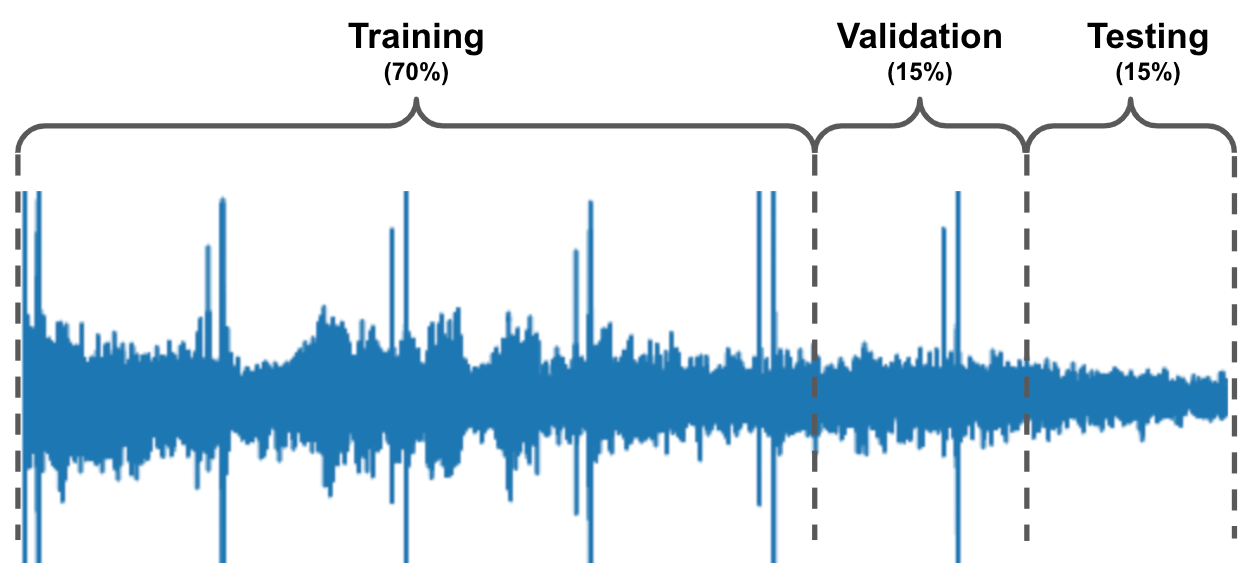

In [16]:
ipd.Image(filename='img1.png', height=256)

In [6]:
full_audio, sr = librosa.load(path='full_audio.wav', sr=None)

In [7]:
training= full_audio[0:int(full_audio.shape[0]*0.7)]
sf.write('training.wav', training, sr)
validation= full_audio[int(full_audio.shape[0]*0.7):int(full_audio.shape[0]*0.85)]
sf.write('validation.wav', validation, sr)
testing= full_audio[int(full_audio.shape[0]*0.85):]
sf.write('testing.wav', testing, sr)

#deleting variables to save memory
del training
del validation
del testing
del full_audio

### Defining Callbacks and Generators

I define a callback for each model which will save a snapshot of the model with the lowest validation loss throughout the training process. 

The generators will be responsible for continuously grabbing a batch of 20 different sound clips from its associated dataset. These sound clips will each be 3 seconds long and will have random start times. The amount of echo and reverb applied to them will also be random. This is depicted in the following image. 

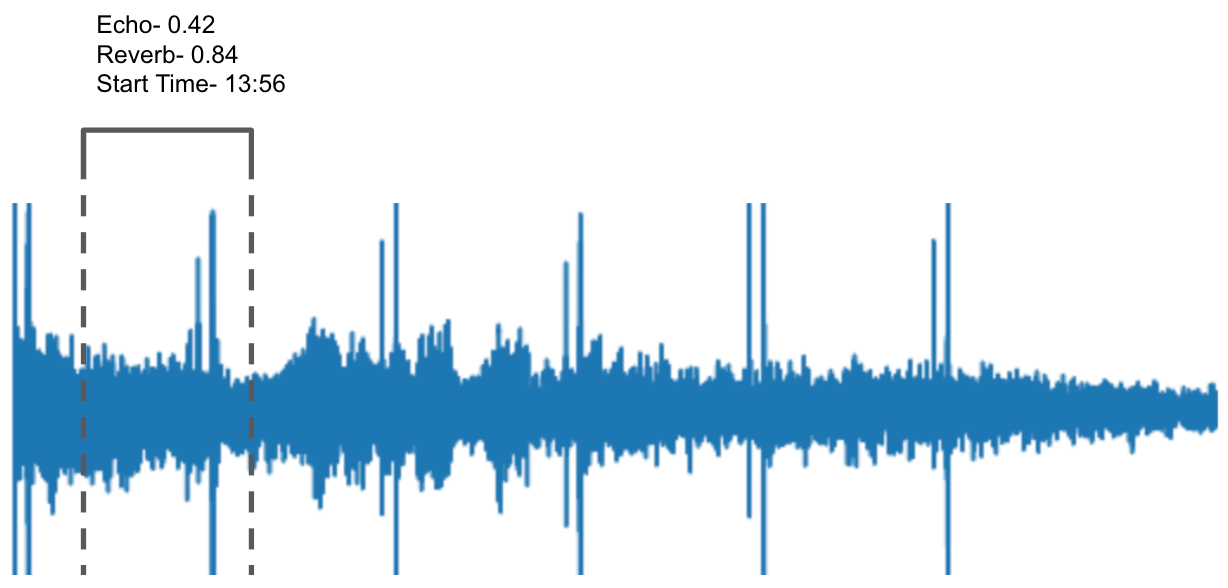

In [17]:
ipd.Image(filename='img2.png', height=256)

In [4]:
best_cb1= callbacks.ModelCheckpoint('model1_best.h5', 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
                                         mode='auto', 
                                         save_freq='epoch')

best_cb2= callbacks.ModelCheckpoint('model2_best.h5', 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
                                         mode='auto', 
                                         save_freq='epoch')

#csv_logger is used in model 2 for the purpose of continuing training 
#following interruptions due to issues that arose with google colab getting stuck
csv_logger = callbacks.CSVLogger('model2_training.csv', append=True)

target_size=(256, 256)
batch_size=20
training_generator= AudioDataGen('training.wav', batch_size=batch_size, target_size=target_size, generator_type='training')
validation_generator= AudioDataGen('validation.wav', batch_size=batch_size, target_size=target_size, generator_type='validation')
testing_generator= AudioDataGen('testing.wav', batch_size=batch_size, target_size=target_size, generator_type='testing')

# Model 1 Building

The first model will have 2 outputs (reverb and echo prediction) but will only have one branch of layers. This architecture is depicted below.

More specifically, I will be using 5 convolutional layers followed by two dense layers, concluding with two linear output nodes. 

By using two distinct output nodes (as opposed to a final layer with two nodes), I am able to track the loss for reverb and echo independently. 

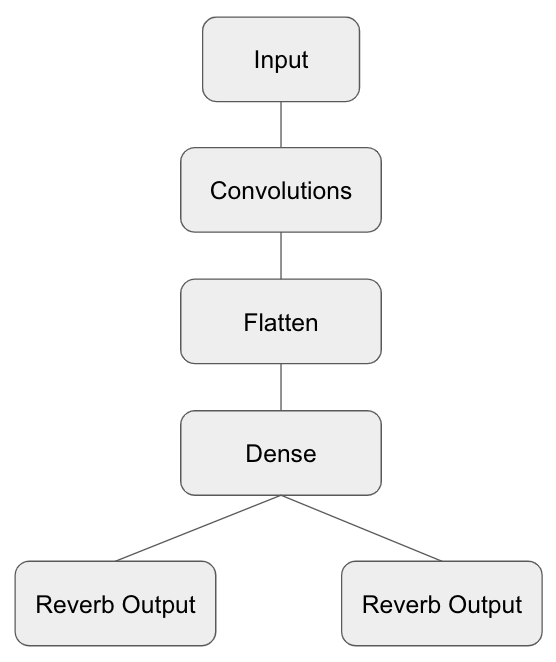

In [18]:
ipd.Image(filename='img3.png', height=350)

In [ ]:
input= layers.Input(shape=training_generator.prep_input().shape)
x= layers.Conv2D(32, (3, 3), activation='relu')(input)
x= layers.MaxPooling2D((2, 2))(x)
x= layers.Dropout(0.1)(x)

x= layers.Conv2D(64, (3, 3), activation='relu')(x)
x= layers.MaxPooling2D((2, 2))(x)
x= layers.Dropout(0.1)(x)

x= layers.Conv2D(64, (3, 3), activation='relu')(x)
x= layers.MaxPooling2D((2, 2))(x)
x= layers.Dropout(0.1)(x)

x= layers.Conv2D(128, (3, 3), activation='relu')(x)
x= layers.MaxPooling2D((2, 2))(x)
x= layers.Dropout(0.1)(x)

x= layers.Conv2D(128, (3, 3), activation='relu')(x)
x= layers.MaxPooling2D((2, 2))(x)
x= layers.Dropout(0.1)(x)

x= layers.Flatten()(x)
x= layers.Dropout(0.2)(x)
x= layers.Dense(128, activation='relu')(x)
x= layers.Dropout(0.2)(x)
x= layers.Dense(64, activation='relu')(x)

output1= layers.Dense(1, activation='linear', name='reverb_output')(x)
output2= layers.Dense(1, activation='linear', name='echo_output')(x)

model = Model(inputs=input, outputs=[output1, output2])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 254, 254, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 127, 127, 32) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 127, 127, 32) 0           max_pooling2d_10[0][0]           
____________________________________________________________________________________________

The model has under 1M trainable parameters which is a reasonable number. I will now compile and train the model. 

The model is trained for 70 epochs which 40 steps for epoch and a batch size of 20. This means that the model will be trained on 800 clips per epoch with a total of 56,000 clips throughout the entire training process. 

The training set is approximately 28 minutes long. Each clip is 3 seconds which gives us 560 distinct raw clips if we quantize the start times for the moment. Each clip has 100 possible combinations of effect parameters if we quantize them by steps of 0.1. This also comes out to 56,000 total possible training records which is equal to the number of clips fed to our model during training. 

Despite this calculation, the reader should be reminded that start times are actually continuous and random along with the effects parameters being applied.  

In [ ]:
model.compile(optimizer='rmsprop',
                loss={'reverb_output':'mean_squared_error',
                      'echo_output':'mean_squared_error'},
                metrics={'reverb_output':'mae', 
                         'echo_output':'mae'})

history = model.fit(
                    training_generator,
                    epochs=70,
                    steps_per_epoch=40,
                    validation_data= validation_generator,
                    validation_steps= 20,
                    callbacks=[best_cb1],
                    verbose=1)


Epoch 1/70
40/40 [==============================] - 106s 3s/step - loss: 0.2456 - reverb_output_loss: 0.1058 - echo_output_loss: 0.1398 - reverb_output_mae: 0.2715 - echo_output_mae: 0.2972 - val_loss: 0.1722 - val_reverb_output_loss: 0.0904 - val_echo_output_loss: 0.0818 - val_reverb_output_mae: 0.2641 - val_echo_output_mae: 0.2421

Epoch 00001: val_loss improved from inf to 0.17223, saving model to model1_best.h5
Epoch 2/70
40/40 [==============================] - 102s 3s/step - loss: 0.1842 - reverb_output_loss: 0.0904 - echo_output_loss: 0.0938 - reverb_output_mae: 0.2573 - echo_output_mae: 0.2569 - val_loss: 0.1693 - val_reverb_output_loss: 0.0857 - val_echo_output_loss: 0.0836 - val_reverb_output_mae: 0.2522 - val_echo_output_mae: 0.2489

Epoch 00002: val_loss improved from 0.17223 to 0.16932, saving model to model1_best.h5
Epoch 3/70
40/40 [==============================] - 102s 3s/step - loss: 0.1854 - reverb_output_loss: 0.0944 - echo_output_loss: 0.0910 - reverb_output_mae: 0

I will now display the echo, reverb, and total loss for the training and validation sets over the course of training. 

I will be comparing the model performance to a benchmark value which we would expect a naive model to achieve. A naive model would simply predict the expectation value of random distribution of echo and reverb parameters. Echo and reverb are chosen via a uniform probability distribution ranging from 0 to 1, so the benchmark loss is calculated according to the formula below.

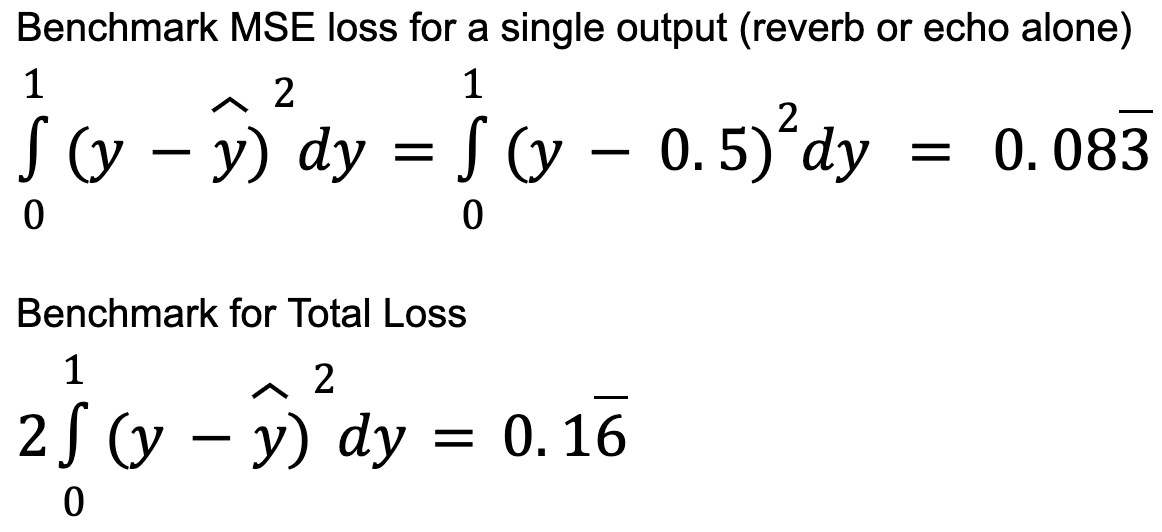

In [81]:
ipd.Image(filename='img5.png', height=250)

By similar reasoning, the benchmark MAE would be 0.25 for both reverb and echo. The benchmark total MAE would be 0.5

In [5]:
def display_training_curves(exclude_first=False):
  #including option to trim first epoch since it dramatically impacts the scale of the graph
  if exclude_first:
    first_index= 1
  else:
    first_index= 0
  
  epochs = range(1, len(history.history['loss']) + 1)[first_index:]

  echo_reverb_benchmark = np.array([0.08333]*len(epochs))
  total_benchmark = np.array([2* 0.08333]*len(epochs))


  reverb_training_loss = history.history['reverb_output_loss'][first_index:]
  reverb_validation_loss = history.history['val_reverb_output_loss'][first_index:]


  echo_training_loss = history.history['echo_output_loss'][first_index:]
  echo_validation_loss = history.history['val_echo_output_loss'][first_index:]

  total_training_loss= history.history['loss'][first_index:]
  total_validation_loss= history.history['val_loss'][first_index:]


  fig = plt.figure(figsize= (10, 15))

  #reverb
  ax=fig.add_subplot(311)
  plt.plot(epochs, reverb_training_loss, 'b', label='Reverb Training Loss')
  plt.plot(epochs, reverb_validation_loss, 'r', label='Reverb Validation Loss')
  plt.plot(epochs, echo_reverb_benchmark, 'g--', label='Reverb Loss Benchmark')
  plt.title('Reverb Training loss', size=16)
  plt.legend()

  #echo
  ax=fig.add_subplot(312)
  plt.plot(epochs, echo_training_loss, 'b', label='Echo training loss')
  plt.plot(epochs, echo_validation_loss, 'r', label='Echo validation loss')
  plt.plot(epochs, echo_reverb_benchmark, 'g--', label='Reverb Loss Benchmark')
  plt.title('Echo Training loss', size=16)
  plt.legend()

  #total
  ax=fig.add_subplot(313)
  plt.plot(epochs, total_training_loss, 'b', label='Total Training Loss')
  plt.plot(epochs, total_validation_loss, 'r', label='Total validation loss')
  plt.plot(epochs, total_benchmark, 'g--', label='Total Loss Benchmark')
  plt.title('Total Training loss', size=16)
  plt.legend()

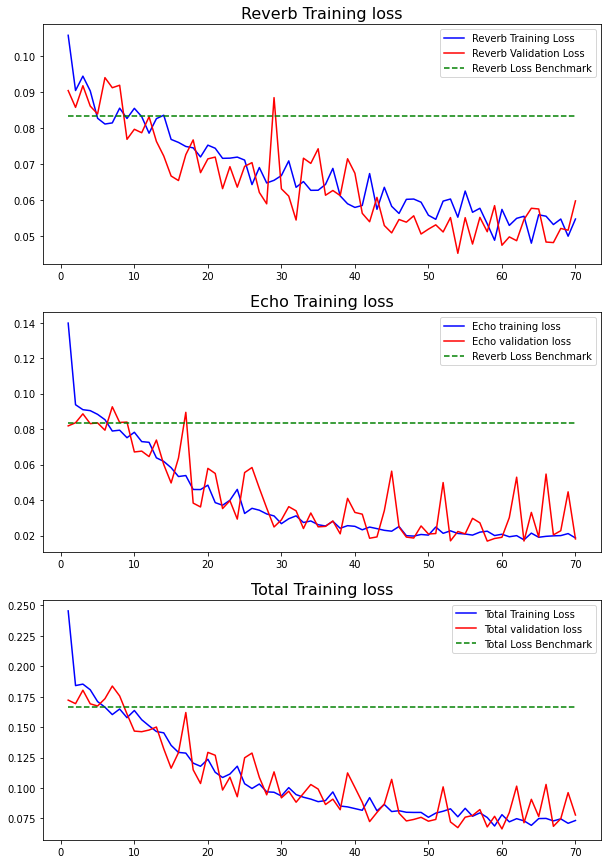

In [ ]:
display_training_curves(exclude_first=False)

We see a healthy decrease in loss throughout training in all 3 graphs. We are well below the benchmark on each. We do see that the echo loss declined more rapidly and ultimately reached a lower value than the reverb loss. The reverb loss appears to decrease roughly linearly and appears to ultimately flatten out in the last few epochs. The validation loss appears to be significantly more turbulent than the training loss which is likely just due to the lower number of validation predictions made after each epoch. 

I will now evaluate the model on the testing data. 

# Model 1 Testing

In [9]:
#load best model from training
model= models.load_model('model1_best.h5')

results=model.evaluate(testing_generator, steps=50)

50/50 [==============================] - 94s 2s/step - loss: 0.0549 - reverb_output_loss: 0.0412 - echo_output_loss: 0.0137 - reverb_output_mae: 0.1630 - echo_output_mae: 0.0891


In [10]:
for i, metric_name in enumerate(model.metrics_names):
  print('{}: {}'.format(metric_name, round(results[i], 4)))

loss: 0.0549
reverb_output_loss: 0.0412
echo_output_loss: 0.0137
reverb_output_mae: 0.163
echo_output_mae: 0.0891


This model scored a total loss of 0.0519 which is significantly lower than the 0.1666 benchmark value. Typical guitar amplifier effects contain dials that range from 0 to 10. With the MAE returned above, this would mean that the predicted echo value would be less than one notch off from the actual value on one of these dials while the predicted reverb is off by about 1.6 notches, which is pretty good. 

I will now build a function to grab some of the best and worst predictions from the testing data and accumulate data on how the total loss varies over the range of possible echo and reverb values. 

## Best and Worst Testing Clips

In [14]:
#function to scan over many testing clips and collect stats, raw audio array, high/low scoring clips
def parameter_scan(iterations=100):
  #parameter_values is an 11X11 array of lists to store loss values for echoes and reverbs ranging from 0.0, 0.1, ... 1.0
  parameter_values= [[[] for _ in range(11)] for _ in range(11)]
  #these lists will repeatedly be appended to, sorted and trimmed to keep the top/bottom 3 clips
  highest_loss= []
  lowest_loss= []

  for j in range(iterations):
    #each iteration generates a full batch (default of 20)
    fx_params= testing_generator.generate_fx_params()
    audio_clips= np.asarray([testing_generator.prep_input(i, j, k, return_audio=True) for i, j, k  in fx_params])
    sgrams= np.asarray([testing_generator.prep_input(i, j, k, return_audio=False) for i, j, k  in fx_params])

    preds= np.array(model.predict(sgrams))
    reverb_pred= preds[0].reshape(batch_size,)
    echo_pred= preds[1].reshape(batch_size,)

    start_times= np.array([float(i)/testing_generator.sr for i, j, k in fx_params])
    reverb_actuals= np.array([j for i, j, k in fx_params])
    echo_actuals= np.array([k for i, j, k in fx_params])

    reverb_loss = (reverb_pred - reverb_actuals)**2
    echo_loss= (echo_pred - echo_actuals)**2
    total_loss= reverb_loss + echo_loss

    #clip_dict contains all of the information we want for our top/bottom 3 clips
    for i in range(len(total_loss)):
      clip_dict = {'clip_tensor':audio_clips[i],
                  'start_time': start_times[i],
                  'reverb_actual':reverb_actuals[i],
                  'echo_actual':echo_actuals[i],
                  'reverb_pred':reverb_pred[i],
                  'echo_pred':echo_pred[i],
                  'reverb_loss':reverb_loss[i],
                  'echo_loss':echo_loss[i],
                  'total_loss':total_loss[i]
                  }
      #append, sort, trim lists to maintain top/bottom 3
      highest_loss.append(clip_dict)
      highest_loss= sorted(highest_loss, key=lambda k: k['total_loss'], reverse=True)[0:3]
      lowest_loss.append(clip_dict)
      lowest_loss = sorted(lowest_loss, key=lambda k: k['total_loss'])[0:3]

    #multiply and round echo/reverb values to correspond to an index of the parameter_values matrix
    for j in range(len(reverb_actuals)):
      x_index, y_index = round(10*reverb_actuals[j]), round(10*echo_actuals[j])
      parameter_values[x_index][y_index].append(total_loss[j])
  
  #the parameter_values array is an 11X11 matrix of lists of loss 
  #We will now replace each list with the mean of that list
  for x in range(11):
    for y in range(11):
      l = parameter_values[x][y]
      #if there were no loss values recorded for this combination of echo and reverb, use the benchmark value instead
      #this is a highly unlikely scenerio due to there being 5000 samples and only 121 possible combinations
      if l==[]:
        l=0.1667
      else:
        l= np.array(l).mean()
      
      parameter_values[x][y]=l

  return highest_loss, lowest_loss, parameter_values


In [ ]:
highest_loss, lowest_loss, parameter_values = parameter_scan(250)

In [ ]:
#save the results for later use in case of interruption
with open('model1_evaluation.pickle', 'wb') as f:
    pickle.dump([highest_loss, lowest_loss, parameter_values], f)

In [15]:
#function for printing stats on a particular prediction
def inspect_top_clip(clip_dict):
  keys= ['total_loss',
       'reverb_actual',
       'reverb_pred',
       'reverb_loss',
       'echo_actual',
       'echo_pred',
       'echo_loss',
       'start_time']
  for key in keys:
    print('{}: {}'.format(key, round(float(clip_dict[key]), 4)))

Play the clips below to hear the testing samples with the highest and lowest loss values.

### Clip with highest loss

In [ ]:
inspect_top_clip(highest_loss[0])
ipd.Audio(highest_loss[0]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.5421
reverb_actual: 0.99
reverb_pred: 0.7084
reverb_loss: 0.0793
echo_actual: 0.07
echo_pred: 0.7503
echo_loss: 0.4628
start_time: 226.0568


### Clip with 2nd highest loss

In [ ]:
inspect_top_clip(highest_loss[1])
ipd.Audio(highest_loss[1]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.5027
reverb_actual: 0.91
reverb_pred: 0.6558
reverb_loss: 0.0646
echo_actual: 0.14
echo_pred: 0.8018
echo_loss: 0.438
start_time: 224.7834


### Clip with 3rd highest loss

In [ ]:
inspect_top_clip(highest_loss[2])
ipd.Audio(highest_loss[2]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.4867
reverb_actual: 0.98
reverb_pred: 0.673
reverb_loss: 0.0942
echo_actual: 0.01
echo_pred: 0.6365
echo_loss: 0.3925
start_time: 189.6516


All 3 clips with the highest error involve a bit overestimation of the echo. The first two clips involve fast guitar picking. I suspect that these fast conecutive souns were mistaken as echoes due to the similar time scale between the echo effect (100ms) and the consecutive guitar notes. The third clip does not contain fast picking, but chords are strummed in such a fashion that notes are played rapidly in succession in a staccato style which could also be mistaken for echo. 

### Clip with lowest loss

In [ ]:
inspect_top_clip(lowest_loss[0])
ipd.Audio(lowest_loss[0]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.22
reverb_pred: 0.22
reverb_loss: 0.0
echo_actual: 0.23
echo_pred: 0.2276
echo_loss: 0.0
start_time: 354.2424


### Clip with 2nd lowest loss

In [ ]:
inspect_top_clip(lowest_loss[1])
ipd.Audio(lowest_loss[1]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.55
reverb_pred: 0.5493
reverb_loss: 0.0
echo_actual: 0.69
echo_pred: 0.6945
echo_loss: 0.0
start_time: 43.9139


### Clip with 3rd lowest loss

In [ ]:
inspect_top_clip(lowest_loss[2])
ipd.Audio(lowest_loss[2]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.7
reverb_pred: 0.6964
reverb_loss: 0.0
echo_actual: 0.35
echo_pred: 0.353
echo_loss: 0.0
start_time: 196.9802


Each of these clips have distinct notes which do not blend in or overlap with one another. The echo and reverb values do not contain any extreme values either (close to 0 or 1). 

I will now build a heat map of the average total loss on testing clips as a function of echo and reverb value. This visual was created by generating and evaluating 5000 predictions on the testing data. 

# Error as a Function of Effects Parameters 

In [25]:
def show_loss_grid():
  fig= plt.figure(figsize=(9,7))
  fig.suptitle('Mean Loss as a Function of Reverb and Echo Values', fontsize=20)
  axis_vals= np.arange(0.0,1.1,.1).round(1)
  ax=sns.heatmap(parameter_values, xticklabels=axis_vals, yticklabels=axis_vals)
  #invert so echo is increasing vertically
  ax.invert_yaxis()
  plt.xlabel("Reverb", fontsize=14)
  plt.ylabel("Echo", fontsize=14)
  plt.show()

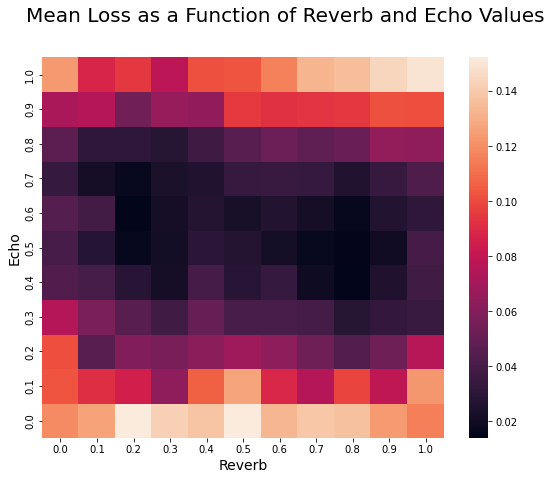

In [ ]:
show_loss_grid()

Interestingly, there appears to be two clusters where the model performs best:
- Mid range echo, with reverb around 0.2
- Mid range echo with reverb around 0.8

Its understandable why the areas of best performance are roughly at 0.5 echo since this is the "safe" prediction that a naive model would predict. I do not understand why there are two clusters. Perhaps the model has become good at telling whether or not significant reverb has been applied but is not very good at estimating its value. This may be worth further investigation in the future. 

# Model 2 Building

Like the previous model, this 2nd model will also include 2 outputs. However, this model will also have an entire branch dedicated to each output. The idea here is that the model may learn echo and reverb better if the training parameters in each are fully dedicated to predicting a single type of patter as opposed to both simultaneously. 

Each branch is identical in architecture to the single branch used on model 1. Therefore, there will be roughly double the amount of trainable parameters which could lead to more representational power. 

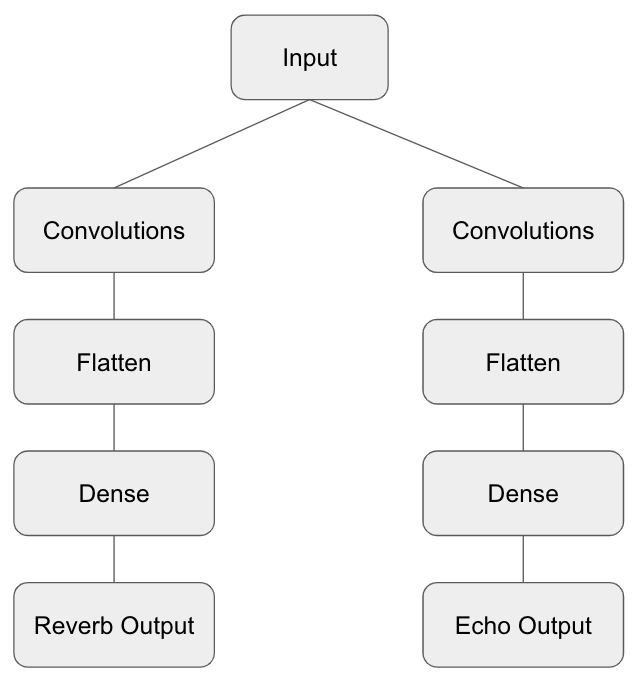

In [19]:
ipd.Image(filename='img4.png', height=350)

In [55]:
input= layers.Input(shape=training_generator.prep_input().shape)
def build_branch():
  x= layers.Conv2D(32, (3, 3), activation='relu')(input)
  x= layers.MaxPooling2D((2, 2))(x)
  x= layers.Dropout(0.1)(x)

  x= layers.Conv2D(64, (3, 3), activation='relu')(x)
  x= layers.MaxPooling2D((2, 2))(x)
  x= layers.Dropout(0.1)(x)

  x= layers.Conv2D(64, (3, 3), activation='relu')(x)
  x= layers.MaxPooling2D((2, 2))(x)
  x= layers.Dropout(0.1)(x)

  x= layers.Conv2D(128, (3, 3), activation='relu')(x)
  x= layers.MaxPooling2D((2, 2))(x)
  x= layers.Dropout(0.1)(x)

  x= layers.Conv2D(128, (3, 3), activation='relu')(x)
  x= layers.MaxPooling2D((2, 2))(x)
  x= layers.Dropout(0.1)(x)

  x= layers.Flatten()(x)
  x= layers.Dropout(0.2)(x)
  x= layers.Dense(128, activation='relu')(x)
  x= layers.Dropout(0.2)(x)
  x= layers.Dense(64, activation='relu')(x)
  return x

branch1= build_branch()
branch2= build_branch()

output1= layers.Dense(1, activation='linear', name='reverb_output')(branch1)
output2= layers.Dense(1, activation='linear', name='echo_output')(branch2)

model = Model(inputs=input, outputs=[output1, output2])

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 254, 254, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 254, 254, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 127, 127, 32) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

As expected, the number of trainable parameters is roughly double. 

In the code below, the reader will see that a previously trained model and its training statistics is being loaded. This was implemented for model 2 since Google Colab was having issues and would often get stuck in the middle of training. By writing training results to a csv and periodically saving the best model, I was able to continue training whenever one of these interruptions occurred. 

Since the model still seemed to be improving after 70 epochs, I ended up training model 2 for 110 epochs. 

In [6]:
#load the previous model and its training stats if continuing training from interruption
if os.path.exists('model2_training.csv'):
  model2_history= pd.read_csv('model2_training.csv')
  remaining_epochs= 110-model2_history.shape[0]
  model= models.load_model('model2_best.h5')
else:
  remaining_epochs=70
print('Remaining Epochs: {}'.format(remaining_epochs))

Remaining Epochs: 16


In [7]:
model.compile(optimizer='rmsprop',
                loss={'reverb_output':'mean_squared_error',
                      'echo_output':'mean_squared_error'},
                metrics={'reverb_output':'mae', 
                         'echo_output':'mae'})

history = model.fit(
                    training_generator,
                    epochs=remaining_epochs,
                    steps_per_epoch=40,
                    validation_data= validation_generator,
                    validation_steps= 20,
                    callbacks=[best_cb2, csv_logger],
                    verbose=1)

Epoch 1/16
40/40 [==============================] - 118s 3s/step - loss: 0.0640 - reverb_output_loss: 0.0489 - echo_output_loss: 0.0151 - reverb_output_mae: 0.1771 - echo_output_mae: 0.0936 - val_loss: 0.0653 - val_reverb_output_loss: 0.0401 - val_echo_output_loss: 0.0252 - val_reverb_output_mae: 0.1644 - val_echo_output_mae: 0.1171

Epoch 00001: val_loss improved from inf to 0.06525, saving model to model2_best.h5
Epoch 2/16
40/40 [==============================] - 114s 3s/step - loss: 0.0639 - reverb_output_loss: 0.0480 - echo_output_loss: 0.0159 - reverb_output_mae: 0.1761 - echo_output_mae: 0.0955 - val_loss: 0.0669 - val_reverb_output_loss: 0.0471 - val_echo_output_loss: 0.0198 - val_reverb_output_mae: 0.1691 - val_echo_output_mae: 0.1088

Epoch 00002: val_loss did not improve from 0.06525
Epoch 3/16
40/40 [==============================] - 114s 3s/step - loss: 0.0595 - reverb_output_loss: 0.0441 - echo_output_loss: 0.0155 - reverb_output_mae: 0.1662 - echo_output_mae: 0.0946 - va

Here I define a dummy class with a "history" attribute so the existing function for printing training curves is compatible with the traing results written to the csv. 

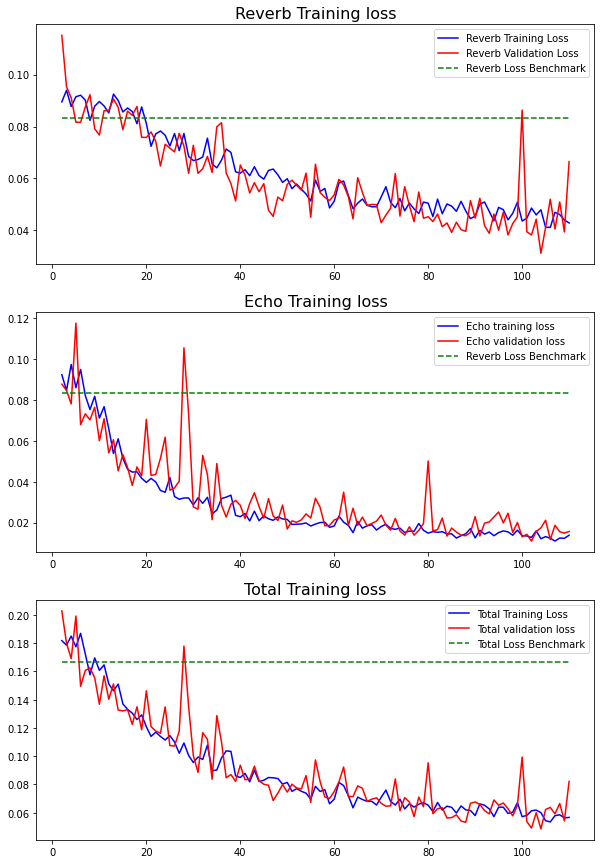

In [8]:
class HistoryObject():
  def __init__(self, history):
    self.history= history

model2_history= pd.read_csv('model2_training.csv')
history= HistoryObject(model2_history)

display_training_curves(exclude_first=True)

Again, we see a healthy decrease in all 3 graphs. Its clear that extending the training to 110 epochs was a good decision. Both the echo and reverb loss reached a lower value than that achieved by the previous model. 

I do notice that the validation curves are more turbulent than in the previous model. This is possible due to the state of the optimizer being reset upon continuing training after interruptions due to Google Colab issues, but I would also expect the same turbulence to be reflected in the training curve as well. Its possible that the higher number of trainable parameters contributed to this. If I were to train this model again, I would use a higher number of steps per epoch for the validation. 

# Model 2 Testing

In [11]:
model= models.load_model('model2_best.h5')

results=model.evaluate(testing_generator, steps=50)

50/50 [==============================] - 93s 2s/step - loss: 0.0395 - reverb_output_loss: 0.0295 - echo_output_loss: 0.0100 - reverb_output_mae: 0.1356 - echo_output_mae: 0.0788


In [12]:
for i, metric_name in enumerate(model.metrics_names):
  print('{}: {}'.format(metric_name, round(results[i], 4)))

loss: 0.0395
reverb_output_loss: 0.0295
echo_output_loss: 0.01
reverb_output_mae: 0.1356
echo_output_mae: 0.0788


Model 2 has surpassed Model 1 by a significant margain. Having a dedicated branch per output seems to have been helpful. The predicted reverb would be off by 1.3 notches on an amplifier whereas the echo would be off by less than 1 notch.

## Best and Worst Testing Clips

In [16]:
highest_loss, lowest_loss, parameter_values = parameter_scan(250)

In [17]:
with open('model2_evaluation.pickle', 'wb') as f:
    pickle.dump([highest_loss, lowest_loss, parameter_values], f)

### Clip with highest loss

In [18]:
inspect_top_clip(highest_loss[0])
ipd.Audio(highest_loss[0]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.5806
reverb_actual: 0.01
reverb_pred: 0.5569
reverb_loss: 0.2991
echo_actual: 0.72
echo_pred: 0.1895
echo_loss: 0.2815
start_time: 0.2458


### Clip with 2nd highest loss

In [19]:
inspect_top_clip(highest_loss[1])
ipd.Audio(highest_loss[1]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.5394
reverb_actual: 0.01
reverb_pred: 0.7164
reverb_loss: 0.499
echo_actual: 0.4
echo_pred: 0.1991
echo_loss: 0.0404
start_time: 103.3058


### Clip with 3rd highest loss

In [20]:
inspect_top_clip(highest_loss[2])
ipd.Audio(highest_loss[2]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.4946
reverb_actual: 0.76
reverb_pred: 0.7713
reverb_loss: 0.0001
echo_actual: 0.9
echo_pred: 0.1968
echo_loss: 0.4945
start_time: 109.4806


This time we see very different kinds of clips than those that were problematic for model 1. The clip with the highest errors includes some note bending which I have not done very often in the rest of the recording. I am not sure how to account for the other two. 

### Clip with lowest loss

In [21]:
inspect_top_clip(lowest_loss[0])
ipd.Audio(lowest_loss[0]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.47
reverb_pred: 0.4672
reverb_loss: 0.0
echo_actual: 0.74
echo_pred: 0.7391
echo_loss: 0.0
start_time: 234.1288


### Clip with 2nd lowest loss

In [22]:
inspect_top_clip(lowest_loss[1])
ipd.Audio(lowest_loss[1]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.25
reverb_pred: 0.2468
reverb_loss: 0.0
echo_actual: 0.62
echo_pred: 0.6211
echo_loss: 0.0
start_time: 220.0233


### Clip with 3rd lowest loss

In [23]:
inspect_top_clip(lowest_loss[2])
ipd.Audio(lowest_loss[2]['clip_tensor'], rate=testing_generator.sr) # load a local WAV file

total_loss: 0.0
reverb_actual: 0.56
reverb_pred: 0.5649
reverb_loss: 0.0
echo_actual: 0.61
echo_pred: 0.6114
echo_loss: 0.0
start_time: 17.9911


Interestingly, the 2nd clip is the same section which model 1 really struggled with. However, this time the clip actually does have echo applied to it. Its unclear whether the model is still mistaking fast picking for echo- It may have gotten lucky since echo just so happened to be applied. 

Lets check the impact on the error if we remove the echo from the same clip.

In [67]:
test_clip= testing_generator.prep_input(start_time=220, reverb=0.25, echo=0.0)

test_clip = np.asarray([test_clip])
test_labels= np.array([[0.25, 0.0]])

results= model.evaluate(test_clip, test_labels)
for i, metric_name in enumerate(model.metrics_names):
  print('{}: {}'.format(metric_name, round(results[i], 4)))

1/1 [==============================] - 0s 40ms/step - loss: 0.1131 - reverb_output_loss: 0.0942 - echo_output_loss: 0.0189 - reverb_output_mae: 0.2803 - echo_output_mae: 0.1250
loss: 0.1131
reverb_output_loss: 0.0942
echo_output_loss: 0.0189
reverb_output_mae: 0.2803
echo_output_mae: 0.125


The error has shot up to 0.1131. Although the model predicted an echo value of 0.125 when there was none, we see a big spike in the loss for reverb. This suggests that the presence or absense of one effect can impact the models ability to predict the other.

However, this small value of predicted error loss also suggests that this model is no longer mistaking the fast picking for echo. 

I will now look at the heatmap of loss as a function of echo and reverb for this model. 

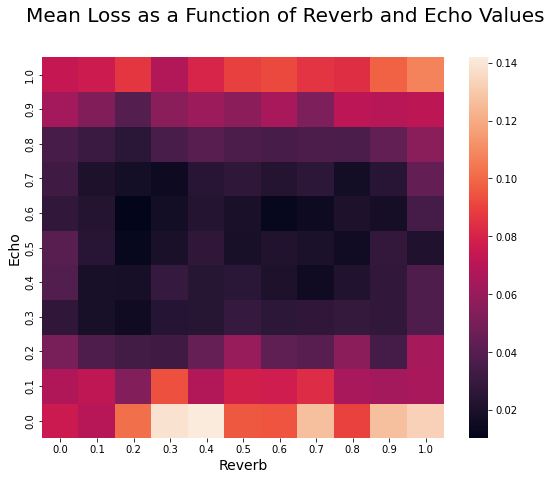

In [26]:
show_loss_grid()

Again, we see the same two-cluster pattern which is interesting. 

# Testing on Spoken Word

I will now test my model on a very different type of data- spoken word. I will be testing on the audio from a 6 minute interview with Thom Yorke and Johnny Greenwood from the band Radiohead seen here:

https://www.youtube.com/watch?v=OcfI82NQGwQ

If the model performs better than the benchmark score, then this will suggest that the model is generalizable to types of audio that it has not encountered before. 

In [79]:
testing_generator= AudioDataGen('interview.wav', batch_size=batch_size, target_size=target_size, generator_type='testing')

In [80]:
results=model.evaluate(testing_generator, steps=50)

for i, metric_name in enumerate(model.metrics_names):
  print('{}: {}'.format(metric_name, round(results[i], 4)))

50/50 [==============================] - 105s 2s/step - loss: 0.1330 - reverb_output_loss: 0.0384 - echo_output_loss: 0.0946 - reverb_output_mae: 0.1493 - echo_output_mae: 0.2477
loss: 0.133
reverb_output_loss: 0.0384
echo_output_loss: 0.0946
reverb_output_mae: 0.1493
echo_output_mae: 0.2477


The model performed reasonably well when it came to predicting the reverb value, but failed to beat the benchmark score for echo. 

This suggests that reverb patterns learned by our model are more generalizable than those learned for echo. This doesn't rule out the possibility that this model can be trained to estimate echo on a general input. Its possible that training the model on a dataset of various types of audio output will allow it to learn to recognize echo in general audio clips that are different from what it has seen before. 

Despite the success of reverb prediction on this spoken word data, the loss is still significantly higher than what it scored on the unseen guitar audio. Again, this model would likely benefit from being trained on a greater variety of audio.

# Conclusions and Next Steps

Overall, both models did very well at predicting echo and reverb applied to guitar data. My initial goal was to limit the project to a simple case that had the highest likihood of success as a proof of concept that such a model could work. Now that I have proof of this, there are a number of directions that a project like this can be taken next. I outline several of these below and offer some thoughts on each. 


### Generalizing Model With More Varied Training Set

As already discussed, one option is to expand the variety of training data to include things like other instruments, spoken word, singing, animal sounds, and other miscellaneous audio. Such data is readily available, but there can be a few challenges associated with gathering such data including...

- Recordings may have already had echo and/or reverb applied to them which would compromize our data. All data should include audio with little or no echo or reverb already applied to them. Every room has some quantity of natural reverb which could be troublesome. In my case, I plugged my electric guitar directly into the recording device with no effects applied in order to avoid this. Having effects other than reverb or echo applied to the training data can actually be beneficial.
- Recordings of songs contain multiple instruments which could each have their own effects applied to them already


### Expanding the Space of Effects and Parameters Being Predicted

In this project, I worked with just 2 different effects and limited the predictions to one parameter for each. This project can be expanded to include more parameters for these effects and even other effects entirely (flangers, phasers, etc.). 

When expanding the types of parameters predicted by the model, scalability becomes critical. Although model 2 outperformed model 1, I would likely want to focus on optimizing model 1 if I were to expand this project to include other effects. It is not scalable to have a full sized branch for each output. There are a few high-level architectures which I would consider for such a project....

- An optimized version of Model 1 is one option. I may need to change the number of convolutional and dense layers, or include other special types of layers in the primary branch. Instead of just 2 output notes, there would be a node for every parameter of every effect we wish to make predictions for

- One branch per effect, but with a vector for each output rather than a scaler. This would be a middle ground between model 1 and 2. Each effect would still have its own dedicated branch, but a single branch would be responsible for predicting all of the parameters relevant for is associated effect. This would probably be scalable for a handful of effects but I suspect it would ultimately run into scalability issues before long. 

- Seperate models for each effect. This would be the most maintainable and scalable solution. There can be a preliminary model which uses a multi-label binary classifier as its output layer to predict which effects are present at all in a given sound clip. If a given effect is detected, the output will be passed on to a specialized model for that specific effect. The specialized model will be responsible for predicting all of the parameters associated with that effect. 


### Integration With Popular Recording Software

For this project I used the pysndfx library to programatically apply sound effects. This library was very convenient and easy to work with, but most musicians are using tools like GarageBand, Logic, or other recording tools. 

In order for this model to have utility for such musicians, then one of two things need to be done:

- Adjust the project workflow to use effects from these popular tools. This could be challenging if the deveopers do not provide the appropriate tools or apis to achieve this. 
- Build a mechanism to convert pysndfx effects to the equivalent settings in the popular recording tools. This can be done by appyinig an effect to a soundclip in Garage Band and then using our model to predict the associated parameters. Doing this over a range of parameter values will create a mapping between the two sets of effects. Once mapped, this conversion can be done on the backend of the user-facing tool. 